**0. Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d


In [12]:
cwd = os.getcwd()
print("Current working directory:", cwd)

# Build the path to the JSON file relative to this directory
json_path = os.path.join(cwd, "gaussian_grids", "gaussians_grid.json")

# Normalize the path
json_path = os.path.normpath(json_path)

# Load JSON
gaussians = pd.read_json(json_path)
print(gaussians.head())
print(max(gaussians["intensities"]))

Current working directory: c:\Users\victo\VSCode Folder\UMCG Mass Spec\Thesis\PeakSeparationThesis\GenData
          rt                                                 mz  \
0  10.000000  [150, 150.0095141891, 150.020400515, 150.03059...   
1  10.056727  [150, 150.0087047019, 150.0196320591, 150.0282...   
2  10.113530  [150, 150.0109749417, 150.0206152599, 150.0320...   
3  10.164866  [150, 150.008555188, 150.0183029892, 150.02919...   
4  10.224504  [150, 150.0117885405, 150.0222033668, 150.0313...   

                                         intensities  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

**1. Supporting Visualization**

Heatmap size:  (1000, 100)


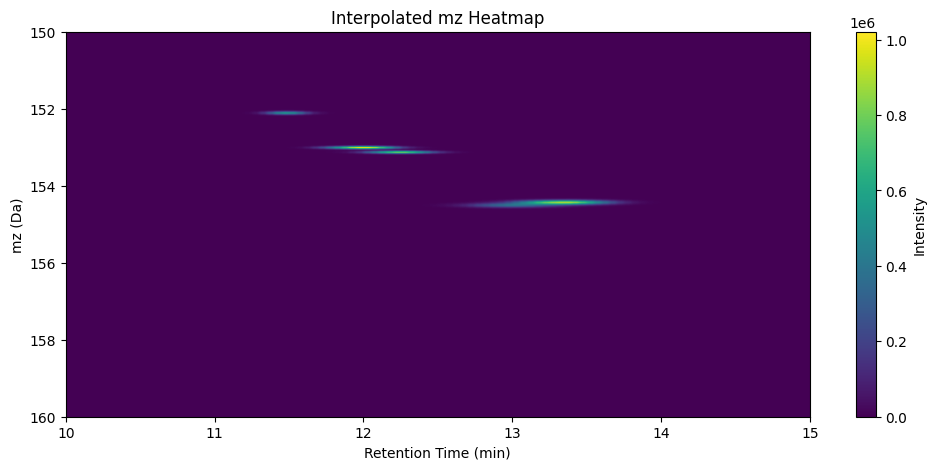

In [ ]:
def plot_heatmap_from_irregular_data(df, title="Interpolated mz Heatmap", zoom=False, mz_points=1000):
    # Step 1: Get rt values
    rt_values = df["rt"].values
    # rt_values_edge = np.linspace(rt_values.min(), rt_values.max(), 1000)

    # Step 2: Define a common mz grid over full range
    all_mz = np.concatenate(df["mz"].values)
    mz_min, mz_max = all_mz.min(), all_mz.max()
    common_mz = np.linspace(mz_min, mz_max, mz_points)

    # Step 3: Interpolate each mz-intensity pair to the common mz grid
    interpolated_matrix = []
    for mz, intensity in zip(df["mz"], df["intensities"]):
        mz = np.array(mz)
        intensity = np.array(intensity).flatten()  # <- flatten here

        interp = interp1d(mz, intensity, kind='linear', bounds_error=False, fill_value=0)
        interpolated_intensity = interp(common_mz)
        interpolated_matrix.append(interpolated_intensity)

    intensity_matrix = np.array(interpolated_matrix)
    intensity_matrix = intensity_matrix.T  # Transpose to have rt as rows and mz as columns
    
    # print("Rt and mz length: ", len(rt_edges), len(mz_edges))
    print("Heatmap size: ", intensity_matrix.shape)

    # Step 4: Plot heatmap
    plt.figure(figsize=(12, 5))
    plt.imshow(intensity_matrix,
        extent=[rt_values[0], rt_values[-1], common_mz[-1], common_mz[0]],
        aspect='auto',
        cmap='viridis')
    plt.colorbar(label='Intensity')
    plt.xlabel('Retention Time (min)')
    plt.ylabel('mz (Da)')
    plt.title(title)

    # Optional zoom
    if zoom:
        plt.xlim(zoom.get('xlim', (rt_values[0], rt_values[-1])))
        plt.ylim(zoom.get('ylim', (common_mz[0], common_mz[-1])))

    plt.show()
    
    fig = px.imshow(
        intensity_matrix,
        origin='lower',
        aspect='auto',
        labels=dict(x="Retention Time", y="m/z", color="Intensity"),
        x=rt_values,
        y=common_mz,
        color_continuous_scale="Viridis"
    )
    fig.update_layout(title="2D Image Plot of LC-MS Data",
        width=800,       # ← set your desired width in pixels
        height=600)
    fig.show()


plot_heatmap_from_irregular_data(df=gaussians)

**2. Data Preprocessing**

In [22]:
def data_preprocessing(df):
    # Correctly pair mz with intensities
    exploded_data = []

    for _, row in df.iterrows():
        mz_list = row['mz']
        intensity_list = row['intensities']
        
        # Ensure mz and intensity lists have the same length before pairing them
        if len(mz_list) == len(intensity_list):
            # Create pairs of (mz, intensity) for each row
            for mz, intensity in zip(mz_list, intensity_list):
                exploded_data.append({'rt': row['rt'], 'mz': mz, 'intensity': intensity})

    # Create a new DataFrame with the exploded data
    exploded_df = pd.DataFrame(exploded_data)

    # Ensure intensities are numeric
    exploded_df['intensity'] = pd.to_numeric(exploded_df['intensity'], errors='coerce')

    # Filter out rows where intensity is zero or NaN
    filtered_data = exploded_df[exploded_df['intensity'] > 0]

    return filtered_data

# Assuming 'gaussians' is your original DataFrame
preprocessed_gaussians = data_preprocessing(gaussians)

# Output Check
print(f"-----\nRows: {len(preprocessed_gaussians)}\nFirst 5 Rows:\n{preprocessed_gaussians.head()}\n-----")

-----
Rows: 47371
First 5 Rows:
       rt          mz      intensity
103  10.0  151.024564  6.422853e-323
104  10.0  151.035677  3.587058e-317
105  10.0  151.047543  4.121831e-311
106  10.0  151.058347  1.184064e-305
107  10.0  151.067682  5.558271e-301
-----


**3. Count Peaks**

Number of peaks detected: 327
